# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

<!-- Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision) -->
让我们利用参数高效微调方法(PEFT)的最新进展, 微调大型图像到文本模型! 我们将通过本教程展示可以微调 3B 比例模型(半精度约 6GB)

<!-- Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset. -->
在这里, 我们将使用上传到 Hub 的 [足球运动员](https://huggingface.co/datasets/ybelkada/football-dataset) 虚拟数据集。图像和字幕都是手动选择的。
查看[文档](https://huggingface.co/docs/datasets/image_dataset)以了解如何创建和上传您自己的图像文本数据集。

## Set-up environment

In [ ]:
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

## Load the image captioning dataset

<!-- Let's load the image captioning dataset, you just need few lines of code for that. -->
让我们加载图像字幕数据集, 您只需要几行代码。

In [1]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

<!-- Let's retrieve the caption of the first example: -->
让我们取出第一个例子的标题:

In [2]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

<!-- And the corresponding image -->
其相应的图像

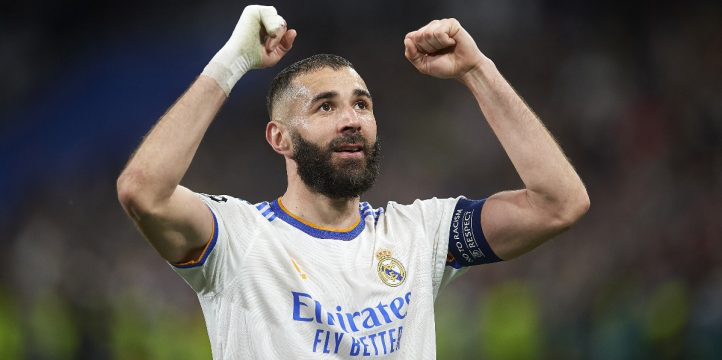

In [3]:
dataset[0]["image"]

## Create PyTorch Dataset

<!-- Let's define below the dataset as well as the data collator! -->
让我们在下面定义数据集以及数据整理器!

In [4]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt") # different from image_captioning_blip.ipynb
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]                                                            # different from image_captioning_blip.ipynb
        return encoding

def collate_fn(batch): # new
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            # example["pixel_values"].shape = torch.Size([3, 224, 224])
            # processed_batch["pixel_values"].shape = torch.Size([len(batch), 3, 224, 224])
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]           # its shape = torch.Size([len(batch), 13])
            processed_batch["attention_mask"] = text_inputs["attention_mask"] # its shape = torch.Size([len(batch), 13])
    return processed_batch


## Load model and processor

In [ ]:
# load_in_8bit=True requires the following package(https://huggingface.co/docs/bitsandbytes/main/en/installation)
! pip install bitsandbytes

In [5]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration # different from image_captioning_blip.ipynb

# https://huggingface.co/Salesforce/blip2-opt-2.7b
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# https://huggingface.co/ybelkada/blip2-opt-2.7b-fp16-sharded
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True) # different from image_captioning_blip.ipynb

/home/qj00182/miniconda3/envs/robohusky/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

/home/qj00182/miniconda3/envs/robohusky/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<!-- Next we define our `LoraConfig` object. We explicitly tell  -->
接下来我们定义`LoraConfig`对象。准确地说

In [6]:
from peft import LoraConfig, get_peft_model # new

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


<!-- Now that we have loaded the processor, let's load the dataset and the dataloader: -->
现在我们已经加载了 processor, 让我们加载 dataset 和 dataloader:

In [7]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## Train the model

<!-- Let's train the model! Run the simply the cell below for training the model -->
让我们训练模型! 运行下面的简单单元来训练模型

In [8]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # different from image_captioning_blip.ipynb

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(200):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 6.05859375
Loss: 5.3828125
Epoch: 1
Loss: 4.89453125
Loss: 3.58203125
Epoch: 2
Loss: 3.5234375
Loss: 4.03125
Epoch: 3
Loss: 3.25390625
Loss: 2.5078125
Epoch: 4
Loss: 2.84375
Loss: 3.7890625
Epoch: 5
Loss: 3.015625
Loss: 2.4609375
Epoch: 6
Loss: 1.671875
Loss: 1.90625
Epoch: 7
Loss: 1.97265625
Loss: 1.86328125
Epoch: 8
Loss: 1.43359375
Loss: 1.8271484375
Epoch: 9
Loss: 1.541015625
Loss: 1.470703125
Epoch: 10
Loss: 1.4814453125
Loss: 0.923828125
Epoch: 11
Loss: 1.2705078125
Loss: 0.8720703125
Epoch: 12
Loss: 1.0078125
Loss: 0.818359375
Epoch: 13
Loss: 1.0986328125
Loss: 0.7001953125
Epoch: 14
Loss: 0.873046875
Loss: 0.7431640625
Epoch: 15
Loss: 0.78857421875
Loss: 0.703125
Epoch: 16
Loss: 0.75927734375
Loss: 0.62353515625
Epoch: 17
Loss: 0.51513671875
Loss: 0.7333984375
Epoch: 18
Loss: 0.70458984375
Loss: 0.552734375
Epoch: 19
Loss: 0.436767578125
Loss: 0.260009765625
Epoch: 20
Loss: 0.41015625
Loss: 0.27880859375
Epoch: 21
Loss: 0.4853515625
Loss: 0.5341796875
Epoch: 22
L

## Inference

<!-- Let's check the results on our train dataset -->
让我们检查一下训练数据集上的结果

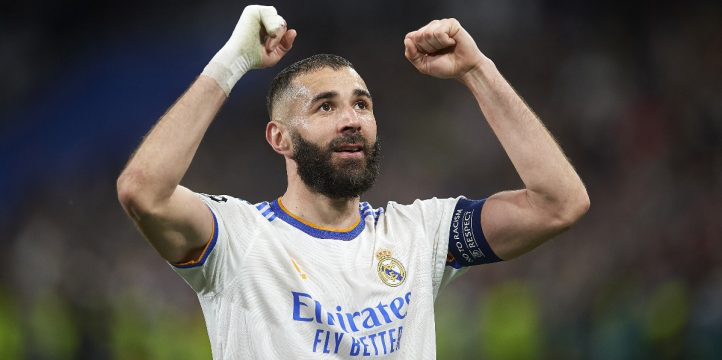

In [9]:
# load image
example = dataset[0]
image = example["image"]
image

In [10]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Benzema after Real Mardid's win against PSG in March 2018


## Push to Hub

In [13]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [14]:
model.push_to_hub("ybelkada/blip2-opt-2.7b-football-captions-adapters")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ybelkada/blip2-opt-2.7b-football-captions-adapters/commit/94febcd3b3278e1dbd3d72f7902b03fedeb4bede', commit_message='Upload model', commit_description='', oid='94febcd3b3278e1dbd3d72f7902b03fedeb4bede', pr_url=None, pr_revision=None, pr_num=None)

## Load from the Hub

<!-- Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!
Please restart the runtime to run the cell below! -->
训练完成后, 您可以将 model 和 processor 推送到 Hub 上, 以便稍后使用。
同时, 您可以使用我们微调过的模型!
请重新运行, 以运行下面的单元!

In [ ]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor # different from image_captioning_blip.ipynb
from peft import PeftModel, PeftConfig                                # new

peft_model_id = "ybelkada/blip2-opt-2.7b-football-captions-adapters"  # new
config = PeftConfig.from_pretrained(peft_model_id)                    # new

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto") # different from image_captioning_blip.ipynb
model = PeftModel.from_pretrained(model, peft_model_id)               # new

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

<!-- Let's check the results on our train dataset! -->
让我们检查一下训练数据集上的结果!

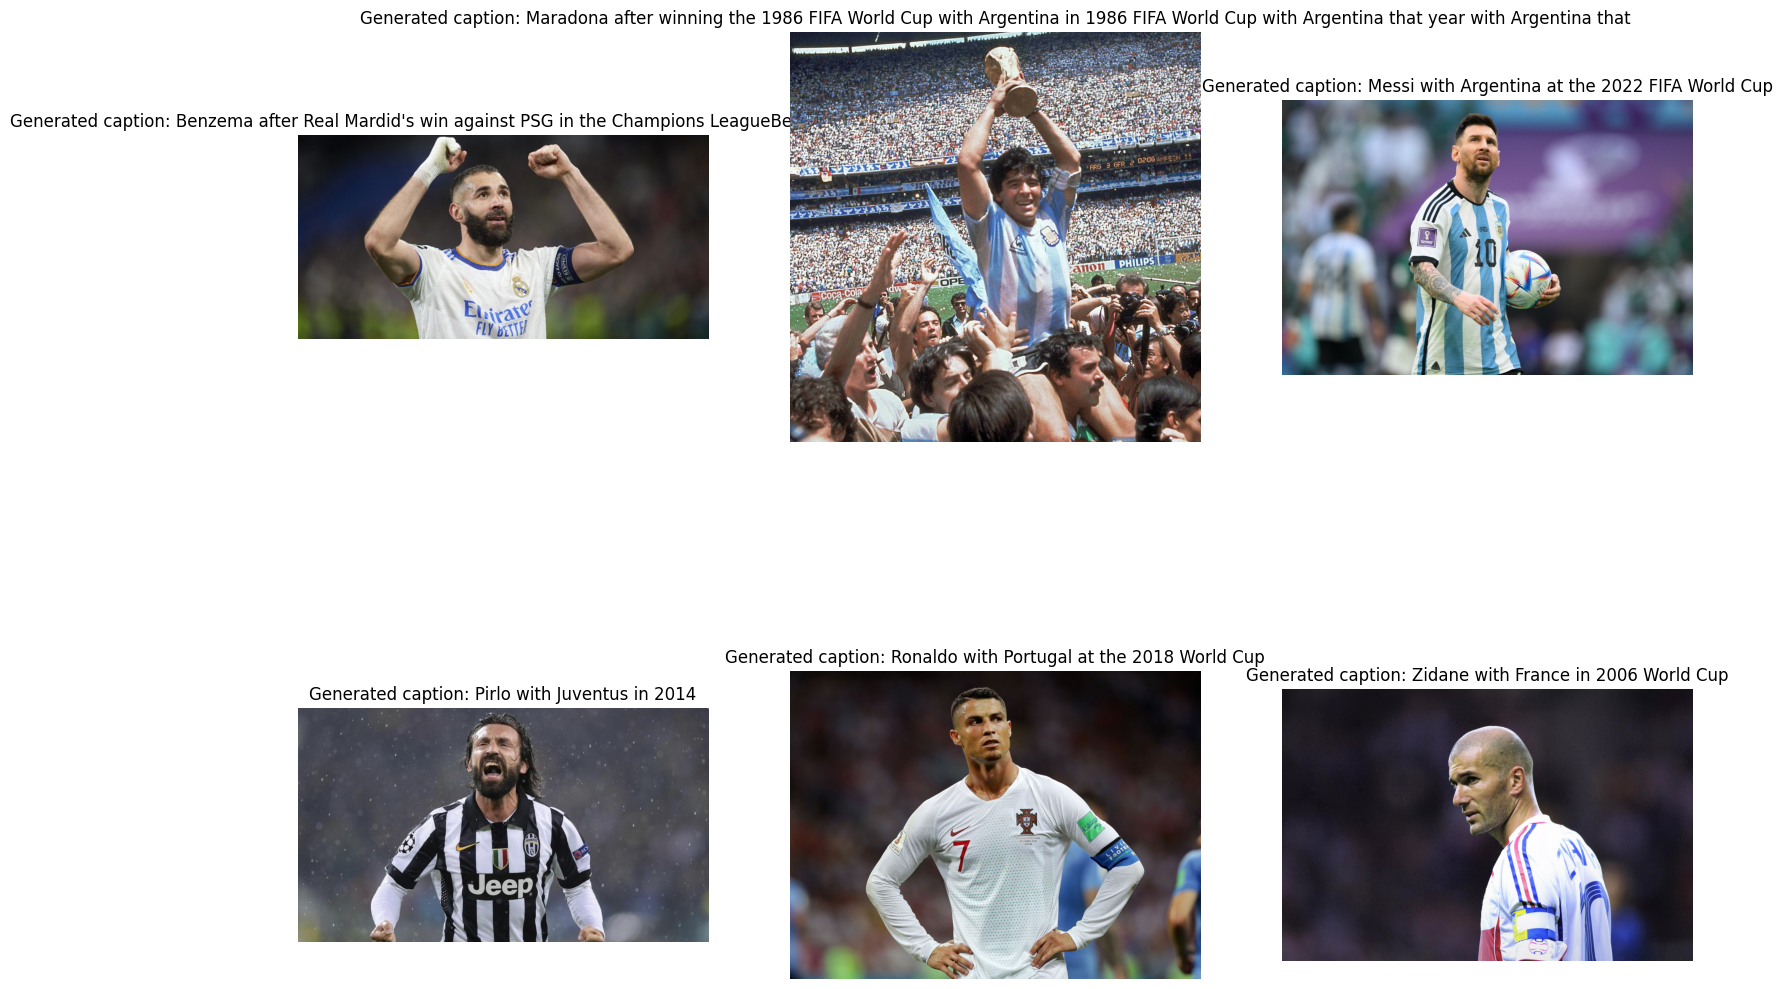

In [11]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")